# Smile faces

Change emotion of face to happy


In [1]:
#@title #**View GPU info** { display-mode: "form" }
!nvidia-smi

Sun Mar  7 04:18:19 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## <b><font color="red" size="+2" >Start</font></b>

In [2]:
#@title ### Install the required components { display-mode: "form" }
%%time
%tensorflow_version 1.x
# !pip install tensorflow-gpu==1.14  
# !pip install tensorflow-gpu==1.15.0 # linux 1.15 also works but not on windows

!pip install gdown
!pip install loguru

# !pip install gast==0.2.2  # older version -- to resolve module 'gast' has no attribute 'Num

TensorFlow 1.x selected.
     |████████████████████████████████| 61kB 3.8MB/s 
CPU times: user 87 ms, sys: 31.2 ms, total: 118 ms
Wall time: 5.43 s


In [3]:
#@title ### Google drive file downloader and string helper { display-mode: "form" }
from gdown import download
from loguru import logger

import string 
import random 


def download_drive_file(file_id, output):
    """
    Download file from google drive

    Args:
        file_id (str): google drive file-id to download
        output (str): path to write file

    Returns:
        Bool: Return True if successfull else False.
    """
    try:
        # download from google drive
        url = f'https://drive.google.com/uc?id={file_id}'
        logger.info("downloading file from google drive.")
        download(url, output, quiet=False)
        return True
    except Exception as e:
        logger.error(e)
        logger.error("Error while downloading file from google drive. Manually add model checkpoint.")
        return False


def generate_unique_str(allow_dashes=True):
    """
    Generate unique string using uuid package

    Args:
        allow_dashes (bool, optional): If true use uuid4() otherwise use hex that will skip dash in names. Defaults to True.
    """
    import uuid

    if allow_dashes:
        unique_str = str(uuid.uuid4())
    else:
        unique_str = uuid.uuid4().hex
    return unique_str


def generate_random_str(length=5):
    """
    generating random strings
    """
    # using random.choices() 
    # generating random strings  
    res = ''.join(
        random.choices(
            string.ascii_uppercase + string.digits,
            k = length
        )
    ) 
    # print("The generated random string : " + str(res)) 
    return res

## Clone encoder and face modification repository

In [4]:
%cd "/content"

/content


In [5]:
#@title ### Clone repository { display-mode: "form" }
!git clone https://gitlab.com/nivrattituito/stylegan2encoder.git

Cloning into 'stylegan2encoder'...
remote: Enumerating objects: 21, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 376 (delta 7), reused 0 (delta 0), pack-reused 355
Receiving objects: 100% (376/376), 14.01 MiB | 43.47 MiB/s, done.
Resolving deltas: 100% (131/131), done.


In [6]:
#@title ### Move inside repository { display-mode: "form" }
%cd "/content/stylegan2encoder"

/content/stylegan2encoder


## Read and siplay image

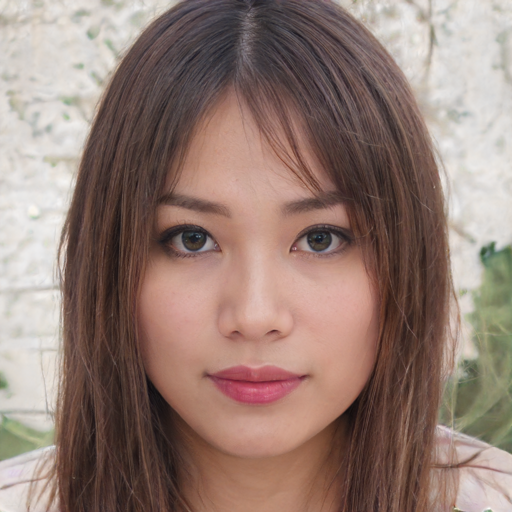

In [11]:
#@title Input Image
from PIL import Image

pil_image = Image.open("/content/stylegan2encoder/data/images/146.png")
display(pil_image.resize((512, 512)))

## Generator configuration for latent modification

In [8]:
#@title ### Load packages { display-mode: "form" }
import argparse
import os
import shutil
import numpy as np

import dnnlib
import dnnlib.tflib as tflib
import pretrained_networks
import projector
import dataset_tool
from training import dataset
from training import misc

from loguru import logger

In [9]:
#@title ### Loading generator network { display-mode: "form" }
%%time

network_pkl='gdrive:networks/stylegan2-ffhq-config-f.pkl'

logger.info('Loading networks from "%s"...' % network_pkl)

# tflib.init_tf()

generator_network, discriminator_network, Gs_network = pretrained_networks.load_networks(
    network_pkl
)


2021-03-07 04:19:08.235 | INFO     | __main__:<module>:4 - Loading networks from "gdrive:networks/stylegan2-ffhq-config-f.pkl"...


Setting up TensorFlow plugin "fused_bias_act.cu": Preprocessing... Compiling... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Preprocessing... Compiling... Loading... Done.
CPU times: user 9.28 s, sys: 1.62 s, total: 10.9 s
Wall time: 48.4 s


In [10]:
#@title ### Configure the generator { display-mode: "form" }

w_avg = Gs_network.get_var('dlatent_avg')
noise_vars = [var for name, var in Gs_network.components.synthesis.vars.items() if name.startswith('noise')]
Gs_syn_kwargs = dnnlib.EasyDict()
Gs_syn_kwargs.output_transform = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
Gs_syn_kwargs.randomize_noise = False
Gs_syn_kwargs.minibatch_size = 1
truncation_psi = 0.5


## <b><font color="red" size="+3" >Generate photos and animations</font></b>

In [14]:
#@title ### Latent modification utility { display-mode: "form" }

def move_latent_and_save(latent_vector, direction_file, coeffs, Gs_network, Gs_syn_kwargs):
    direction = np.load('latent_directions/' + direction_file)
    os.makedirs('results/'+direction_file.split('.')[0], exist_ok=True)
    for i, coeff in enumerate(coeffs):
        new_latent_vector = latent_vector.copy()
        new_latent_vector[0][:8] = (latent_vector[0] + coeff*direction)[:8]
        images = Gs_network.components.synthesis.run(new_latent_vector, **Gs_syn_kwargs)
        result = Image.fromarray(images[0], 'RGB')
        result.thumbnail(size, Image.ANTIALIAS)
        result.save('results/'+direction_file.split('.')[0]+'/'+str(i).zfill(3)+'.png')
        if len(coeffs)==1:
          return result

def move_latent(latent_vector, direction_file, coeffs, Gs_network, Gs_syn_kwargs):
    direction = np.load('latent_directions/' + direction_file)
    # os.makedirs('results/'+direction_file.split('.')[0], exist_ok=True)
    for i, coeff in enumerate(coeffs):
        new_latent_vector = latent_vector.copy()
        new_latent_vector[0][:8] = (latent_vector[0] + coeff*direction)[:8]
        images = Gs_network.components.synthesis.run(new_latent_vector, **Gs_syn_kwargs)
        result = Image.fromarray(images[0], 'RGB')
        result.thumbnail(size, Image.ANTIALIAS)
        # result.save('results/'+direction_file.split('.')[0]+'/'+str(i).zfill(3)+'.png')
        
        # display(result.resize((512, 512)))

        if len(coeffs)==1:
          return result

In [37]:
#@title Read latent
latent_file = "/content/stylegan2encoder/data/dlatents/146_img.npy"

v = np.load(latent_file)

## convert w into w+
v = np.tile(v, (18, 1))
v = np.array([v])

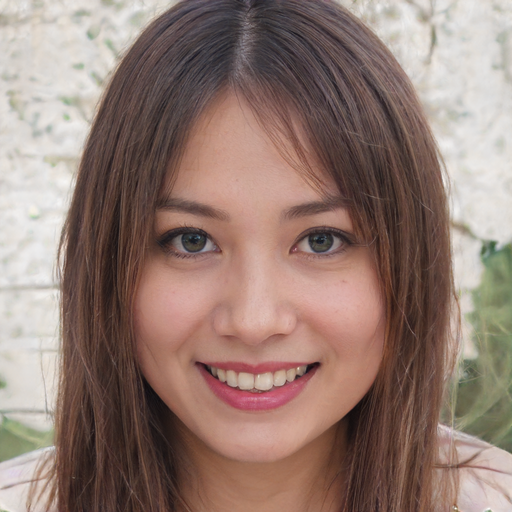

In [35]:
#@title #**Modify the face in photo** { run: "auto", display-mode: "form" }

#@markdown  **Note:** Currently optimized for smile modification. Age and other attributes modification needs diffrent intensities to work.

Note: 

#@markdown **Choose what you would like to change.:**
parameter = 'smile' #@param ["age", "angle_horizontal", "angle_vertical", "beauty", "emotion_angry", "emotion_disgust", "emotion_easy", "emotion_fear", "emotion_happy", "emotion_sad", "emotion_surprise", "eye_distance", "eye_eyebrow_distance", "eye_ratio", "eyes_open", "face_shape", "gender", "glasses", "height", "lip_ratio", "mouth_open", "mouth_ratio", "nose_mouth_distance", "nose_ratio", "nose_tip", "race_black", "race_white", "race_yellow", "smile", "width"]
direction_file = parameter + '.npy'
direction_name = direction_file.split('.')[0]
#@markdown **Parameter intensity:**
intensity = -2.4 #@param {type:"slider", min:-3, max:3, step:0.1}

coeffs = [intensity]

# print(coeffs)

#@markdown **Image resolution:**
resolution = "512" #@param [128, 256, 512, 1024]
size = int(resolution), int(resolution)

modified_face_result = move_latent(v, direction_file, coeffs, Gs_network, Gs_syn_kwargs)

display(modified_face_result.resize((512, 512)))

In [38]:
#@title #**Animating a face modification** { display-mode: "form" }

import imageio
import moviepy.editor as mpy

# # v = np.load('latent_representations/'+fn[0])
# v = np.load(latent_file)
# v = np.array([v])

#@markdown **Choose what you would like to change.:**
parameter = 'smile' #@param ["age", "angle_horizontal", "angle_vertical", "beauty", "emotion_angry", "emotion_disgust", "emotion_easy", "emotion_fear", "emotion_happy", "emotion_sad", "emotion_surprise", "eye_distance", "eye_eyebrow_distance", "eye_ratio", "eyes_open", "face_shape", "gender", "glasses", "height", "lip_ratio", "mouth_open", "mouth_ratio", "nose_mouth_distance", "nose_ratio", "nose_tip", "race_black", "race_white", "race_yellow", "smile", "width"]
direction_file = parameter + '.npy'
direction_name = direction_file.split('.')[0]
#@markdown **Starting intensity:**
start_intensity = -3 #@param {type:"slider", min:-3, max:3, step:0.1}
#@markdown **Finishing intensity:**
finish_intensity = 1 #@param {type:"slider", min:-3, max:3, step:0.1}
#@markdown **Number of frames:**
frames = 40 #@param {type:"slider", min:10, max:100, step:1}

if finish_intensity > start_intensity:

  duration = abs(start_intensity)+abs(finish_intensity)
  steps = round(duration/frames,2)
  coeffs = []

  for i in range(int(start_intensity*100), int(finish_intensity*100), int(steps*100)):
    coeffs.append(i/100)

  #@markdown **Animation Resolution:**
  resolution = "512" #@param [128, 256, 512, 1024]
  size = int(resolution), int(resolution)

  move_latent_and_save(v, direction_file, coeffs, Gs_network, Gs_syn_kwargs)

  #@markdown **Add video Invert:**

  add_invert = True #@param {type:"boolean"}
  face_img = []
  img = os.listdir("results/"+direction_name)
  img.sort()
  for i in img:
      file_head, ext = os.path.splitext(i)
      if ext in [".png", ".jpg", ".jpeg"]:
          face_img.append(imageio.imread("results/" + direction_name + "/"+i))
  
  if add_invert == True:
    for j in reversed(face_img):
      face_img.append(j)
  face_img = np.array(face_img)
  imageio.mimsave("results/" + direction_name + "/" + direction_name + ".mp4", face_img)
  display(mpy.ipython_display("results/" + direction_name + "/" + direction_name + ".mp4", height=400, autoplay=1, loop=1))
else:
  print('Starting intensity should be less than the finish!')